# RNN and LSTM Model Comparison

This notebook builds, trains, and evaluates simple RNN and LSTM models for stock price prediction to compare against the LLM-based models.

## 1. Import Libraries

In [46]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


## 2. Load and Prepare Data

In [47]:
import ast

# Load the processed data
train_df = pd.read_csv('../rnn_lstm_data/train_rnn.csv', index_col='Date', parse_dates=True)
val_df = pd.read_csv('../rnn_lstm_data/val_rnn.csv', index_col='Date', parse_dates=True)
test_df = pd.read_csv('../rnn_lstm_data/test_rnn.csv', index_col='Date', parse_dates=True)

# Convert the 'recent_prices' string back to a list of floats
train_df['recent_prices'] = train_df['recent_prices'].apply(ast.literal_eval)
val_df['recent_prices'] = val_df['recent_prices'].apply(ast.literal_eval)
test_df['recent_prices'] = test_df['recent_prices'].apply(ast.literal_eval)

print('Training data shape:', train_df.shape)
print('Validation data shape:', val_df.shape)
print('Test data shape:', test_df.shape)
display(train_df.head())

Training data shape: (8748, 4)
Validation data shape: (1243, 4)
Test data shape: (2477, 4)
 (8748, 4)
Validation data shape: (1243, 4)
Test data shape: (2477, 4)


,ticker,recent_prices,sentiment,actual_price
Date,,,,
2015-01-02 00:00:00+00:00,AAPL,"[27.332500457763672, 27.332500457763672, 27.33...",-0.077200,26.562500
2015-01-02 00:00:00+00:00,HSBC,"[47.06999969482422, 47.06999969482422, 47.0699...",0.000000,45.990002
2015-01-02 00:00:00+00:00,PEP,"[94.44000244140624, 94.44000244140624, 94.4400...",0.140500,93.730003
2015-01-02 00:00:00+00:00,0700.HK,"[103.98540496826172, 103.98540496826172, 103.9...",0.000000,104.630707
2015-01-05 00:00:00+00:00,PEP,"[94.44000244140624, 94.44000244140624, 94.4400...",0.295633,93.019997


## 3. Prepare Sequential Data for RNN/LSTM

In [48]:
def create_sequences(df, window_size=5):
    X, y = [], []
    dates = []  # Store dates
    tickers = []  # Store tickers
    recent_prices_list = []  # Store recent prices
    for i in range(len(df)):
        prices = df.iloc[i]['recent_prices']
        sentiment = df.iloc[i]['sentiment']
        target = df.iloc[i]['actual_price']
        
        if prices and len(prices) >= window_size:
            # Combine prices and sentiment
            features = np.column_stack([prices[-window_size:], [sentiment]*window_size])
            X.append(features)
            y.append(target)
            dates.append(df.index[i])  # Store the date
            tickers.append(df.iloc[i]['ticker'])  # Store the ticker
            recent_prices_list.append(prices[-window_size:])  # Store the recent prices used
            
    return np.array(X), np.array(y), dates, tickers, recent_prices_list

WINDOW_SIZE = 5
X_train, y_train, train_dates, train_tickers, train_recent_prices = create_sequences(train_df, WINDOW_SIZE)
X_val, y_val, val_dates, val_tickers, val_recent_prices = create_sequences(val_df, WINDOW_SIZE)
X_test, y_test, test_dates, test_tickers, test_recent_prices = create_sequences(test_df, WINDOW_SIZE)

# Scale the data
# Note: We scale prices and sentiment separately
price_scaler = MinMaxScaler()
X_train_prices = price_scaler.fit_transform(X_train[:, :, 0].reshape(-1, 1)).reshape(X_train.shape[0], WINDOW_SIZE, 1)
X_val_prices = price_scaler.transform(X_val[:, :, 0].reshape(-1, 1)).reshape(X_val.shape[0], WINDOW_SIZE, 1)
X_test_prices = price_scaler.transform(X_test[:, :, 0].reshape(-1, 1)).reshape(X_test.shape[0], WINDOW_SIZE, 1)

# Combine scaled prices with sentiment
X_train_scaled = np.concatenate([X_train_prices, X_train[:, :, 1:]], axis=2)
X_val_scaled = np.concatenate([X_val_prices, X_val[:, :, 1:]], axis=2)
X_test_scaled = np.concatenate([X_test_prices, X_test[:, :, 1:]], axis=2)


print("Data prepared for RNN/LSTM.")
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val_scaled.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)

Data prepared for RNN/LSTM.
X_train shape: (8748, 5, 2)
y_train shape: (8748,)
X_val shape: (1243, 5, 2)
y_val shape: (1243,)
X_test shape: (2477, 5, 2)
y_test shape: (2477,)


## 4. Hyperparameter Tuning

In [49]:
# Define hyperparameter search space
param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3]
}

best_rnn_params = {}
best_rnn_val_loss = float('inf')

best_lstm_params = {}
best_lstm_val_loss = float('inf')

print("Hyperparameter grid defined.")

Hyperparameter grid defined.


## 5. Find Best RNN Model

In [50]:
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        print(f"Training RNN with {units} units and {dropout_rate} dropout...")
        
        model = Sequential([
            SimpleRNN(units, activation='relu', input_shape=(WINDOW_SIZE, 2)),
            Dropout(dropout_rate),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50, # Reduced epochs for faster tuning
            batch_size=32,
            validation_data=(X_val_scaled, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0 # Suppress output for cleaner tuning
        )
        
        val_loss = min(history.history['val_loss'])
        
        if val_loss < best_rnn_val_loss:
            best_rnn_val_loss = val_loss
            best_rnn_params = {'units': units, 'dropout_rate': dropout_rate}
            print(f"  New best RNN val_loss: {val_loss:.4f}")

print(f"\\nBest RNN params: {best_rnn_params}")
print(f"Best RNN validation loss: {best_rnn_val_loss:.4f}")

Training RNN with 32 units and 0.1 dropout...


/Users/angjiayi/code/StockPPOLLMresearch/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  New best RNN val_loss: 1402.7485
Training RNN with 32 units and 0.2 dropout...
  New best RNN val_loss: 1367.0493
Training RNN with 32 units and 0.3 dropout...
  New best RNN val_loss: 1367.0493
Training RNN with 32 units and 0.3 dropout...
Training RNN with 64 units and 0.1 dropout...
Training RNN with 64 units and 0.1 dropout...
Training RNN with 64 units and 0.2 dropout...
Training RNN with 64 units and 0.2 dropout...
Training RNN with 64 units and 0.3 dropout...
Training RNN with 64 units and 0.3 dropout...
Training RNN with 128 units and 0.1 dropout...
Training RNN with 128 units and 0.1 dropout...
Training RNN with 128 units and 0.2 dropout...
Training RNN with 128 units and 0.2 dropout...
Training RNN with 128 units and 0.3 dropout...
Training RNN with 128 units and 0.3 dropout...
\nBest RNN params: {'units': 32, 'dropout_rate': 0.2}
Best RNN validation loss: 1367.0493
\nBest RNN params: {'units': 32, 'dropout_rate': 0.2}
Best RNN validation loss: 1367.0493


## 6. Find Best LSTM Model

In [51]:
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        print(f"Training LSTM with {units} units and {dropout_rate} dropout...")
        
        model = Sequential([
            LSTM(units, activation='relu', input_shape=(WINDOW_SIZE, 2)),
            Dropout(dropout_rate),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        history = model.fit(
            X_train_scaled, y_train,
            epochs=50, # Reduced epochs for faster tuning
            batch_size=32,
            validation_data=(X_val_scaled, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0 # Suppress output for cleaner tuning
        )
        
        val_loss = min(history.history['val_loss'])
        
        if val_loss < best_lstm_val_loss:
            best_lstm_val_loss = val_loss
            best_lstm_params = {'units': units, 'dropout_rate': dropout_rate}
            print(f"  New best LSTM val_loss: {val_loss:.4f}")

print(f"\\nBest LSTM params: {best_lstm_params}")
print(f"Best LSTM validation loss: {best_lstm_val_loss:.4f}")

Training LSTM with 32 units and 0.1 dropout...
  New best LSTM val_loss: 1431.5236
Training LSTM with 32 units and 0.2 dropout...
  New best LSTM val_loss: 1431.5236
Training LSTM with 32 units and 0.2 dropout...
  New best LSTM val_loss: 1384.4083
Training LSTM with 32 units and 0.3 dropout...
  New best LSTM val_loss: 1384.4083
Training LSTM with 32 units and 0.3 dropout...
Training LSTM with 64 units and 0.1 dropout...
Training LSTM with 64 units and 0.1 dropout...
Training LSTM with 64 units and 0.2 dropout...
Training LSTM with 64 units and 0.2 dropout...
Training LSTM with 64 units and 0.3 dropout...
Training LSTM with 64 units and 0.3 dropout...
Training LSTM with 128 units and 0.1 dropout...
Training LSTM with 128 units and 0.1 dropout...
Training LSTM with 128 units and 0.2 dropout...
Training LSTM with 128 units and 0.2 dropout...
Training LSTM with 128 units and 0.3 dropout...
Training LSTM with 128 units and 0.3 dropout...
\nBest LSTM params: {'units': 32, 'dropout_rate': 0

## 7. Train Final Models and Evaluate

Training final RNN model...
Training final LSTM model...
Training final LSTM model...
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
\nPredictions saved to ../results/rnn_lstm_predictions.csv
\nRNN Model - MAE: 27.0991, MAPE: 4.76%
LSTM Model - MAE: 33.8376, MAPE: 6.35%
\nPredictions saved to ../results/rnn_lstm_predictions.csv
\nRNN Model - MAE: 27.0991, MAPE: 4.76%
LSTM Model - MAE: 33.8376, MAPE: 6.35%


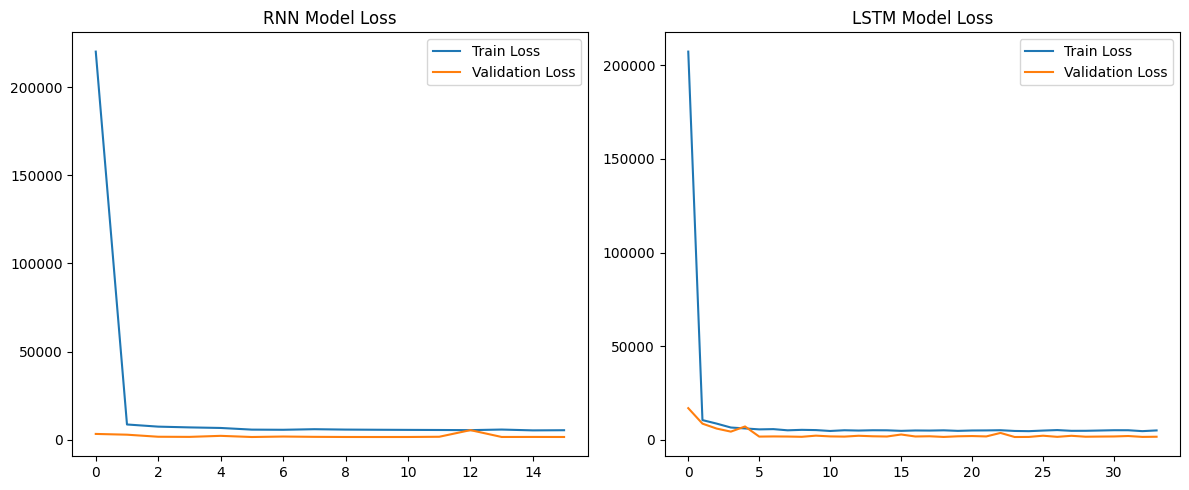

In [52]:
# Train the final RNN model with the best hyperparameters
print("Training final RNN model...")
best_rnn_model = Sequential([
    SimpleRNN(best_rnn_params['units'], activation='relu', input_shape=(WINDOW_SIZE, 2)),
    Dropout(best_rnn_params['dropout_rate']),
    Dense(1)
])
best_rnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = best_rnn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=0
)

# Train the final LSTM model with the best hyperparameters
print("Training final LSTM model...")
best_lstm_model = Sequential([
    LSTM(best_lstm_params['units'], activation='relu', input_shape=(WINDOW_SIZE, 2)),
    Dropout(best_lstm_params['dropout_rate']),
    Dense(1)
])
best_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = best_lstm_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
    verbose=0
)

# Make predictions
rnn_predictions = best_rnn_model.predict(X_test_scaled).flatten()
lstm_predictions = best_lstm_model.predict(X_test_scaled).flatten()

# Create a dataframe with the results including date, ticker, and recent prices
results_df = pd.DataFrame({
    'date': test_dates,
    'ticker': test_tickers,
    'recent_prices': test_recent_prices,
    'actual_price': y_test,
    'rnn_prediction': rnn_predictions,
    'lstm_prediction': lstm_predictions
})

# Save the results
results_df.to_csv('../results/rnn_lstm_predictions.csv', index=False)
print("\\nPredictions saved to ../results/rnn_lstm_predictions.csv")

# Calculate and print MAE and MAPE
mae_rnn = np.mean(np.abs(results_df['rnn_prediction'] - results_df['actual_price']))
mape_rnn = np.mean(np.abs((results_df['actual_price'] - results_df['rnn_prediction']) / results_df['actual_price'])) * 100

mae_lstm = np.mean(np.abs(results_df['lstm_prediction'] - results_df['actual_price']))
mape_lstm = np.mean(np.abs((results_df['actual_price'] - results_df['lstm_prediction']) / results_df['actual_price'])) * 100

print(f"\\nRNN Model - MAE: {mae_rnn:.4f}, MAPE: {mape_rnn:.2f}%")
print(f"LSTM Model - MAE: {mae_lstm:.4f}, MAPE: {mape_lstm:.2f}%")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.legend()

plt.tight_layout()
plt.show()